# LSTM: Sectionals_v1

Train an LSTM to analyze a horse’s past performance sequence and predict the horse's race pattern that reflects its projected strength today.

✅ This model, unless it proves predictive on a standalone apactity, will be fed into the CatBoost/YetiRank model as a feature.

⸻

🔍 How Accurate is Ranking by Sectional Data Alone?

🔥 The Good:

If your LSTM is trained on well-normalized, consistent historical speed signals: • Relative ordering can be quite meaningful • Especially in smaller fields or when you’re identifying top 3–4 finishers • Even if absolute values are off, ranking is often more robust

❄️ The Limitations: • LSTM alone won’t account for today’s track conditions, surface bias, jockey/trainer changes, distance, class jump/drop • It may favor horses that ran fast recently but are now outclassed or mispositioned

In [1]:
# Setup Environment
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ.pop("CUDA_VISIBLE_DEVICES", None)

# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import logging
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import optuna
import torch.nn as nn
import numpy as np
import optuna.visualization as viz
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import (to_date, date_format, lpad, concat_ws, collect_list, struct, 
                                   col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql

In [3]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [4]:
# def gps_sql_queries():
#     queries = {
#         "gps_horse": """
#             SELECT g.course_cd, g.race_date,g.race_number,
#             REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, time_stamp, 
#             longitude, latitude, speed, progress, stride_frequency, g.post_time, location,
#             re.axciskey, h.horse_id, re.official_fin, h.horse_name
#             FROM gpspoint g
#             JOIN results_entries re on g.course_cd = re.course_cd
#                 AND g.race_date = re.race_date
#                 AND g.race_number = re.race_number
#                 AND g.saddle_cloth_number = re.program_num
#             JOIN horse h on re.axciskey = h.axciskey
#             WHERE speed is not null
#             AND progress is not null
#             AND stride_frequency is not null
#             """,
#         "sectionals": """
#             SELECT s.course_cd, s.race_date, s.race_number, h.horse_id, 
#             REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, 
#             s.gate_name, s.gate_numeric, s.length_to_finish, s.sectional_time, s.running_time, 
#             s.distance_back, s.distance_ran, s.number_of_strides, s.post_time, re.official_fin
#             FROM sectionals s
#             JOIN results_entries re on s.course_cd = re.course_cd
#                 AND s.race_date = re.race_date
#                 AND s.race_number = re.race_number
#                 AND s.saddle_cloth_number = re.program_num
#             JOIN horse h on re.axciskey = h.axciskey 
#             WHERE length_to_finish is not null
#             AND sectional_time is not null
#             AND running_time is not null
#             AND distance_back is not null
#             AND distance_ran is not null
#             AND distance_ran is not null
#             AND number_of_strides is not null
#             """
#     }
#     return queries


In [5]:
# queries = gps_sql_queries()
# dfs = load_data_from_postgresql(spark, jdbc_url, jdbc_properties, queries, parquet_dir)
#         # Suppose we have a dictionary of queries
# for name, df in dfs.items():
#     logging.info(f"DataFrame '{name}' loaded. Schema:")
#     df.printSchema()
#     if name == "gps_horse":
#         gps_horse_df = df
#     elif name == "sectionals":
#         sectionals_df = df    
#     else:
#         logging.error(f"Unknown DataFrame name: {name}")
#         continue


In [6]:

# start_time = time.time()
# # gps_horse_df.write.mode("overwrite").parquet(f"{parquet_dir}/gps_horse_df")
# sectionals_df.write.mode("overwrite").parquet(f"{parquet_dir}/sectionals_df")
# logging.info(f"Data written to Parquet in {time.time() - start_time:.2f} seconds")
    

In [7]:
# gps_horse_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/gps_horse_df")
sectionals_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/sectionals_df")


In [8]:
# Convert race_date to a proper date format
sectionals_df = sectionals_df.withColumn("race_date", to_date(col("race_date")))

# Construct a unique race_id using course_cd, race_date, and race_number
sectionals_df = sectionals_df.withColumn(
    "race_id",
    concat_ws(
        "_",
        col("course_cd"),
        date_format(col("race_date"), "yyyyMMdd"),
        lpad(col("race_number").cast("string"), 2, "0")
    )
)


## Create gate_seq_num Column

In [9]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Step 1: Filter out finish rows to compute max gate_numeric per race
non_finish_df = sectionals_df.filter(F.col("gate_name") != "finish")

# Define a window partitioning by race identifiers
race_window = Window.partitionBy("course_cd", "race_date", "race_number")

# Compute maximum gate_numeric for each race (ignoring finish rows)
max_gate_df = non_finish_df.groupBy("course_cd", "race_date", "race_number") \
    .agg(F.max("gate_numeric").alias("max_gate_numeric"))

# Step 2: Join the maximum gate value back to the original DataFrame
joined_df = sectionals_df.join(max_gate_df, on=["course_cd", "race_date", "race_number"], how="left")

# Step 3: Create the new column 'gate_seq_num'
# If the gate is 'finish', assign max_gate_numeric + 0.5, else keep gate_numeric.
sectionals_df = joined_df.withColumn(
    "gate_seq_num",
    F.when(F.col("gate_name") == "finish", F.col("max_gate_numeric") + F.lit(0.5))
     .otherwise(F.col("gate_numeric"))
)

# Optionally, display the results for a single race
sectionals_df.select("saddle_cloth_number", "race_id", "gate_name", "gate_numeric", "gate_seq_num").show(15, truncate=False)

+-------------------+---------------+---------+------------+------------+
|saddle_cloth_number|race_id        |gate_name|gate_numeric|gate_seq_num|
+-------------------+---------------+---------+------------+------------+
|6                  |TKD_20220908_02|0.5f     |0.5         |0.5         |
|6                  |TKD_20220908_02|1.5f     |1.5         |1.5         |
|6                  |TKD_20220908_02|1f       |1.0         |1.0         |
|6                  |TKD_20220908_02|2.5f     |2.5         |2.5         |
|6                  |TKD_20220908_02|2f       |2.0         |2.0         |
|6                  |TKD_20220908_02|3.5f     |3.5         |3.5         |
|6                  |TKD_20220908_02|3f       |3.0         |3.0         |
|6                  |TKD_20220908_02|4.5f     |4.5         |4.5         |
|6                  |TKD_20220908_02|4f       |4.0         |4.0         |
|6                  |TKD_20220908_02|5.5f     |5.5         |5.5         |
|6                  |TKD_20220908_02|5

## Sort

In [11]:

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window_spec = Window.partitionBy("race_id", "horse_id").orderBy(F.asc("gate_seq_num"))
sectionals_df = sectionals_df.withColumn("segment_ordinal", row_number().over(window_spec))


In [12]:
sectionals_df.printSchema()

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- race_id: string (nullable = false)
 |-- max_gate_numeric: double (nullable = true)
 |-- gate_seq_num: double (nullable = true)
 |-- segment_ordinal: integer (nullable = false)



## Assign Target/Relevance:

In [13]:
from pyspark.sql import functions as F

def assign_piecewise_log_labels_spark(df, alpha=30.0, beta=4.0):
    df_out = df.withColumn(
        "relevance",
        F.when(F.col("official_fin") == 1, 70.0)
         .when(F.col("official_fin") == 2, 56.0)
         .when(F.col("official_fin") == 3, 44.0)
         .when(F.col("official_fin") == 4, 34.0)
         .otherwise(F.lit(alpha) / F.log(F.lit(beta) + F.col("official_fin")))
    ).withColumn(
        "top4_label",
        F.when(F.col("official_fin") <= 4, F.lit(1)).otherwise(F.lit(0))
    )
    return df_out

In [14]:
sectionals_df = assign_piecewise_log_labels_spark(sectionals_df)

In [15]:
sectionals_df.printSchema()

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- race_id: string (nullable = false)
 |-- max_gate_numeric: double (nullable = true)
 |-- gate_seq_num: double (nullable = true)
 |-- segment_ordinal: integer (nullable = false)
 |-- relevance: double (nullable = true)
 |-- top4_label: integer (nullable = false)



# Compute Sequence Lenghts

### Drop Rows with >=10 and <=18 Sequences

In [18]:

# Step 1: Compute sequence lengths per horse per race
df_seq_len = sectionals_df.groupBy("race_id", "horse_id").agg(F.count("*").alias("seq_length"))

# Step 2: Filter sequences with length between 10 and 18
filtered_df = df_seq_len.filter((F.col("seq_length") >= 10) & (F.col("seq_length") <= 18))

# Step 3: Join the filtered sequence lengths back with the original data
sectionals_df = sectionals_df.join(filtered_df, on=["race_id", "horse_id"], how="inner")

### Plot Sequence Lengths

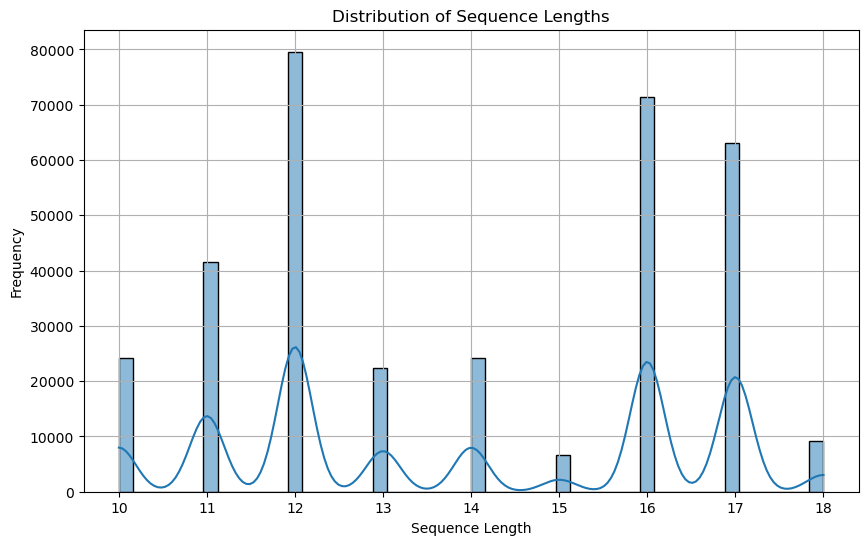

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_seq_len is a DataFrame with a 'seq_length' column
# If df_seq_len is a PySpark DataFrame, convert it to Pandas
df_seq_len_pd = df_seq_len.toPandas()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_seq_len_pd['seq_length'], bins=50, kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Padding Sequences to a Fixed Length

###  Step 1: Convert to Sequence Format

In [25]:
from pyspark.sql.functions import collect_list, sort_array, struct

from pyspark.sql.window import Window
from pyspark.sql.functions import collect_list, struct

def make_sequences(df, features):
    # build the 'feature_struct'
    df = df.select(
        "race_id", "horse_id",
        "segment_ordinal",
        struct(*[F.col(f) for f in features]).alias("feature_struct")
    )

    w = (
        Window.partitionBy("race_id", "horse_id")
              .orderBy(F.asc("segment_ordinal"))
              .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    )

    df = df.withColumn(
        "sequence",
        collect_list("feature_struct").over(w)
    ).withColumn(
        "rn",
        row_number().over(
            Window.partitionBy("race_id", "horse_id").orderBy(F.asc("segment_ordinal"))
        )
    )

    # Now, the "last" row for each partition in ascending order is:
    #   rn == count_of_rows_in_that_partition
    # or you can do a second window with "count(*)" and compare.

    # Simpler approach: use a second window or another column to filter just the final row:

    from pyspark.sql.functions import count

    count_window = Window.partitionBy("race_id", "horse_id")
    df = df.withColumn(
        "count_in_part",
        count("*").over(count_window)
    )

    # Now keep only the row where 'rn == count_in_part'
    df = df.filter(F.col("rn") == F.col("count_in_part"))

    df = df.select("race_id", "horse_id", "sequence")
    return df

In [26]:
features = ["length_to_finish", "sectional_time", "running_time",
            "distance_back", "distance_ran", "number_of_strides"]
all_seq = make_sequences(sectionals_df, features)

In [27]:
all_seq.columns

['race_id', 'horse_id', 'sequence']

In [28]:
# Join race_date and relevance back into our sequences.
# We rename the joined relevance column to avoid duplicates.
all_seq = all_seq.join(
    sectionals_df.select("race_id", "horse_id", "race_date", F.col("relevance").alias("joined_relevance"))
        .dropDuplicates(["race_id", "horse_id"]),
    on=["race_id", "horse_id"],
    how="left"
)
# Remove any pre-existing relevance column and rename the joined one.
all_seq = all_seq.drop("relevance").withColumnRenamed("joined_relevance", "relevance")

In [29]:
all_seq.columns

['race_id', 'horse_id', 'sequence', 'race_date', 'relevance']

### Convert to Pandas

In [30]:
all_pd = all_seq.toPandas()

# Sort by race_date to maintain temporal order
all_pd = all_pd.sort_values("race_date").reset_index(drop=True)

In [32]:
print(all_pd.columns)
all_pd.info()

Index(['race_id', 'horse_id', 'sequence', 'race_date', 'relevance'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342223 entries, 0 to 342222
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   race_id    342223 non-null  object 
 1   horse_id   342223 non-null  int32  
 2   sequence   342223 non-null  object 
 3   race_date  342223 non-null  object 
 4   relevance  342223 non-null  float64
dtypes: float64(1), int32(1), object(3)
memory usage: 11.7+ MB


###  ✅ TimeSeriesSplit with Rolling-Window Cross-Validation

In [36]:
# --- Step 1: Prepare Your Data ---
# Assume full_pd is your Pandas DataFrame with the following columns:
#   - "race_date": the date of the race (used for sorting)
#   - "padded_seq": the padded sequence (a list of dicts or arrays, one per sample)
#   - "relevance": the target variable

# First, sort the DataFrame by race_date to ensure temporal order.
full_pd_sorted = all_pd.sort_values("race_date").reset_index(drop=True)

Dataset time range: 2022-01-01 to 2025-03-23
Fold 1: Train indices 0-57037, Test indices 57038-114074
Fold 2: Train indices 0-114074, Test indices 114075-171111
Fold 3: Train indices 0-171111, Test indices 171112-228148
Fold 4: Train indices 0-228148, Test indices 228149-285185
Fold 5: Train indices 0-285185, Test indices 285186-342222


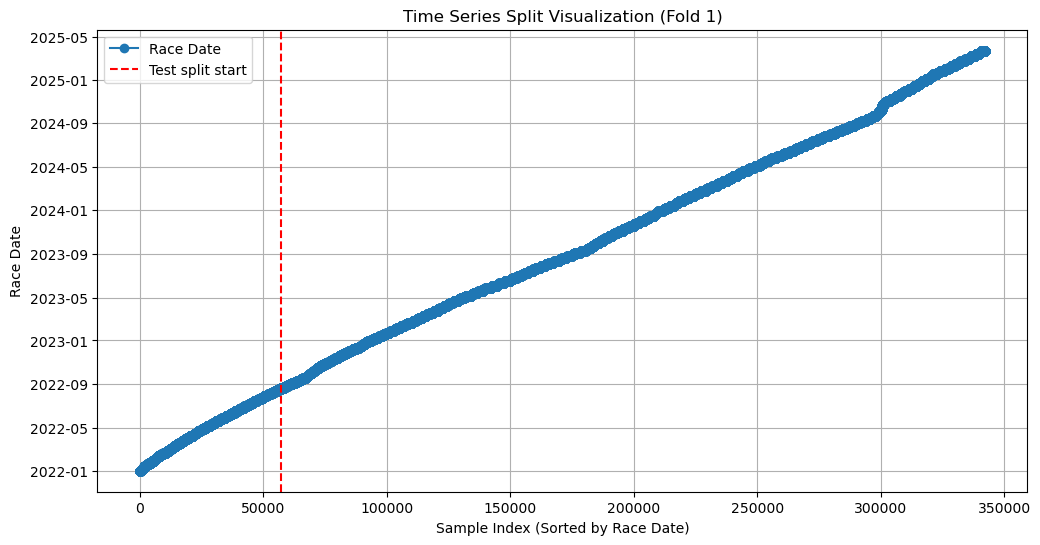

In [37]:
# --- Assume 'all_pd' is your sorted Pandas DataFrame (sorted by race_date) ---
print("Dataset time range:", all_pd["race_date"].min(), "to", all_pd["race_date"].max())

# Create a TimeSeriesSplit object with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Collect indices for each split
splits = list(tscv.split(all_pd))
for fold, (train_idx, test_idx) in enumerate(splits):
    print(f"Fold {fold+1}: Train indices {train_idx[0]}-{train_idx[-1]}, Test indices {test_idx[0]}-{test_idx[-1]}")

# --- Plotting one of the splits for visualization ---
# Let's visualize the first split:
train_idx, test_idx = splits[0]

plt.figure(figsize=(12, 6))
# Plot the race_date for each sample as points
plt.plot(all_pd.index, pd.to_datetime(all_pd["race_date"]), marker='o', linestyle='-', label='Race Date')

# Mark the split boundary: first index of the test set
plt.axvline(x=test_idx[0], color='red', linestyle='--', label='Test split start')

plt.xlabel("Sample Index (Sorted by Race Date)")
plt.ylabel("Race Date")
plt.title("Time Series Split Visualization (Fold 1)")
plt.legend()
plt.grid(True)
plt.show()

### Pad Sequences: 

Convert the sequences to a fixed length (e.g., 150) and prepare them for modeling.

In [42]:
def pad_sequence(seq, target_len):
    # Define a default value for each feature
    pad_val = {
        "length_to_finish": 0.0,
        "sectional_time": 0.0,
        "running_time": 0.0,
        "distance_back": 0.0,
        "distance_ran": 0.0,
        "number_of_strides": 0.0
    }
    # Truncate the sequence if it's longer than target_len
    seq = seq[:target_len]
    # Pad with pad_val if it's shorter than target_len
    return seq + [pad_val] * (target_len - len(seq))


def prepare_unified_lstm_dataset(df, target_len=18):
    # Drop duplicates and filter out rows without a relevance score
    df = df.drop_duplicates(subset=["race_id", "horse_id"])
    df = df[df["relevance"].notna()]
    
    # Create a new column 'padded_seq' by applying pad_sequence to the existing 'sequence' column
    df["padded_seq"] = df["sequence"].apply(lambda x: pad_sequence(x, target_len))
    
    # Build a 3D numpy array where each sample's sequence is an array of 7 feature values
    X_all = np.array([
        [
            [
                d["length_to_finish"],
                d["sectional_time"],
                d["running_time"],
                d["distance_back"],
                d["distance_ran"],
                d["number_of_strides"]
            ] for d in seq
        ] for seq in df["padded_seq"]
    ], dtype=np.float32)
    
    # Extract the target variable (relevance) as a 1D array
    y_all = df["relevance"].values.astype(np.float32)
    return X_all, y_all, df




In [43]:
X_all, y_all, full_pd = prepare_unified_lstm_dataset(all_pd, target_len=18)
# Now, X_all should have shape (num_samples, 18, 7) with your new features.
print("X_all shape:", X_all.shape)

X_all shape: (342223, 18, 6)


# Split & Normalize

## Define Helper Functions

In [44]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib

# --------------------------------------------
# Outlier Capping (Train/Val versions)
# --------------------------------------------
def cap_outliers_X_train_only(X_train, lower_percentile=1, upper_percentile=99):
    """
    Compute bounds from X_train, apply to X_train.
    Returns: (X_train_capped, (lower_bounds, upper_bounds))
    """
    num_samples, seq_len, num_features = X_train.shape
    X_flat = X_train.reshape(-1, num_features)
    
    lower_bounds = np.percentile(X_flat, lower_percentile, axis=0)
    upper_bounds = np.percentile(X_flat, upper_percentile, axis=0)

    X_flat_capped = np.clip(X_flat, lower_bounds, upper_bounds)
    X_train_capped = X_flat_capped.reshape(num_samples, seq_len, num_features)
    return X_train_capped, (lower_bounds, upper_bounds)

def cap_outliers_X_val(X_val, bounds):
    """
    Apply the train-derived bounds to X_val, no new fit.
    """
    (lower_bounds, upper_bounds) = bounds
    num_samples, seq_len, num_features = X_val.shape
    X_flat = X_val.reshape(-1, num_features)
    
    X_flat_capped = np.clip(X_flat, lower_bounds, upper_bounds)
    return X_flat_capped.reshape(num_samples, seq_len, num_features)

def cap_outliers_y_train_only(y_train, lower_percentile=1, upper_percentile=99):
    """
    Compute bounds from y_train, apply to y_train.
    Returns: (y_train_capped, (lower_bound, upper_bound))
    """
    lower_bound = np.percentile(y_train, lower_percentile)
    upper_bound = np.percentile(y_train, upper_percentile)
    y_train_capped = np.clip(y_train, lower_bound, upper_bound)
    return y_train_capped, (lower_bound, upper_bound)

def cap_outliers_y_val(y_val, y_bounds):
    (lower_bound, upper_bound) = y_bounds
    return np.clip(y_val, lower_bound, upper_bound)

# --------------------------------------------
# PyTorch Dataset
# --------------------------------------------
class HorseRaceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Build a "Train/Val" Prep Function

In [45]:
def build_lstm_dataloaders_time_series(
    X_all, 
    y_all, 
    batch_size=64, 
    n_splits=5,
    save_scalers=True,
    scaler_X_path="training_scalers_gpsscaler_X.pkl",
    scaler_y_path="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_gpsscaler_y.pkl"
):
    """
    1) Do TimeSeriesSplit on (X_all, y_all).
    2) Use last split as train/val.
    3) Cap outliers + scale on train only, apply same transforms to val.
    4) Build DataLoaders for train/val.
    5) Optionally save the scalers.
    """

    # ---------- (A) TimeSeriesSplit ----------
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = list(tscv.split(X_all))
    train_idx, val_idx = splits[-1]  # last split for validation

    X_train_raw, X_val_raw = X_all[train_idx], X_all[val_idx]
    y_train_raw, y_val_raw = y_all[train_idx], y_all[val_idx]

    # ---------- (B) Outlier capping ----------
    # Fit bounds on train, apply to val
    X_train_capped, X_bounds = cap_outliers_X_train_only(X_train_raw)
    X_val_capped = cap_outliers_X_val(X_val_raw, X_bounds)

    y_train_capped, y_bounds = cap_outliers_y_train_only(y_train_raw)
    y_val_capped = cap_outliers_y_val(y_val_raw, y_bounds)

    # ---------- (C) Scaling (train only) ----------
    # Flatten train
    num_train, seq_len, num_features = X_train_capped.shape
    X_train_flat = X_train_capped.reshape(-1, num_features)

    scaler_X = StandardScaler()
    X_train_flat_scaled = scaler_X.fit_transform(X_train_flat)
    X_train_scaled = X_train_flat_scaled.reshape(num_train, seq_len, num_features)

    # Flatten val, transform
    num_val = X_val_capped.shape[0]
    X_val_flat = X_val_capped.reshape(-1, num_features)
    X_val_flat_scaled = scaler_X.transform(X_val_flat)
    X_val_scaled = X_val_flat_scaled.reshape(num_val, seq_len, num_features)

    # Scale y (MinMaxScaler as example)
    scaler_y = MinMaxScaler()
    y_train_2d = y_train_capped.reshape(-1, 1)
    y_train_scaled = scaler_y.fit_transform(y_train_2d).flatten()

    y_val_2d = y_val_capped.reshape(-1, 1)
    y_val_scaled = scaler_y.transform(y_val_2d).flatten()

    # Optional: save scalers to disk for inference
    if save_scalers:
        joblib.dump(scaler_X, scaler_X_path)
        joblib.dump(scaler_y, scaler_y_path)
        print(f"Saved {scaler_X_path} and {scaler_y_path}")

    # ---------- (D) Build PyTorch Datasets & Loaders ----------
    train_dataset = HorseRaceDataset(X_train_scaled, y_train_scaled)
    val_dataset   = HorseRaceDataset(X_val_scaled, y_val_scaled)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, train_dataset, val_dataset, scaler_X, scaler_y

In [46]:
# Suppose X_all, y_all is your complete dataset (raw, unscaled).
train_loader, val_loader, train_dataset, val_dataset, scaler_X, scaler_y = \
    build_lstm_dataloaders_time_series(
        X_all, 
        y_all, 
        batch_size=64, 
        n_splits=5,
        save_scalers=True,  # if you want to save them
        scaler_X_path="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionalscaler_X.pkl",
        scaler_y_path="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionalscaler_y.pkl"
    )


Saved /home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionalscaler_X.pkl and /home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionalscaler_y.pkl


# 🧠 Basic LSTM Model for Sequence Classification

In [47]:
class HorseRaceLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=64, out_embed_size=8, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, 1)
        
        # A small linear to produce an 8D embedding:
        self.embed_projector = nn.Linear(hidden_size, out_embed_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        # 'out' shape: (batch, seq_len, hidden_size)
        # 'h_n[-1]' shape: (batch, hidden_size) if num_layers=1

        # We'll take the last time-step for both score + embedding
        last_hidden = out[:, -1, :]  # shape (batch, hidden_size)

        # 1) Final scalar:
        final_score = self.fc(last_hidden)

        # 2) A small embedding (8D):
        embed_vector = self.embed_projector(last_hidden)  
        # shape (batch, out_embed_size)

        return final_score.squeeze(1), embed_vector

In [48]:
# Assuming train_loader is defined and built using normalized X_all and y_all:
for batch_X, batch_y in train_loader:
    print("Batch X stats:")
    print(" - min:", batch_X.min().item())
    print(" - max:", batch_X.max().item())
    print(" - mean:", batch_X.mean().item())
    
    print("Batch y stats:")
    print(" - min:", batch_y.min().item())
    print(" - max:", batch_y.max().item())
    print(" - mean:", batch_y.mean().item())
    break

Batch X stats:
 - min: -1.8323636054992676
 - max: 4.033766269683838
 - mean: -0.009553148411214352
Batch y stats:
 - min: 0.0
 - max: 0.9999999403953552
 - mean: 0.344913125038147


In [49]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name 0:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 2
Device name 0: NVIDIA RTX A6000


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 🧪 Mini Training Loop

In [51]:
def train_one_epoch(model, dataloader, optimizer, main_loss_fn, device,
                    alpha=0.01, verbose=False):
    """
    Train one epoch with a secondary embedding loss.
    
    Returns the average total loss = main_loss + alpha * embed_loss.
    """
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        
        # model returns (score, embed_vec)
        score, embed_vec = model(X_batch)
        
        # 1) Main MSE loss
        main_loss = main_loss_fn(score, y_batch)
        
        # 2) Secondary objective (example: L2 norm of embed_vec)
        embed_loss = embed_vec.norm(dim=1).mean()  # or something else
        total_loss = main_loss + alpha * embed_loss
        
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
    
    return running_loss / len(dataloader)

In [52]:
# Evaluate function to compute validation loss
def evaluate_lstm(model, dataloader, loss_fn, device, verbose=False):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Unpack the two outputs
            score, embed_vec = model(X_batch)

            # Only compare 'score' with 'y_batch'
            loss = loss_fn(score, y_batch)
            
            total_loss += loss.item()

            if verbose:
                print(f"Batch Loss: {loss.item()}")

    return total_loss / len(dataloader)

In [53]:
def objective(trial):
    # 1) Suggest which optimizer
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # 2) Suggest a learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    # If using SGD, also pick momentum
    # (You can wrap this in a conditional if you only want momentum for SGD)
    momentum = 0.0
    if optimizer_name == "SGD":
        momentum = trial.suggest_float("momentum", 0.0, 0.9, step=0.1)
    
    # 3) Example of other hyperparams
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128])
    num_layers  = trial.suggest_int("num_layers", 1, 2)
    out_embed_size = 8 
    dropout     = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)

    # Print or log the chosen hyperparams for debugging
    print(f"[Trial {trial.number}] "
          f"opt={optimizer_name}, lr={lr:.1e}, momentum={momentum}, "
          f"hidden={hidden_size}, layers={num_layers}, dropout={dropout}")

    # 4) Build a fresh model inside the objective
    model = HorseRaceLSTM(
        input_size=6,
        hidden_size=hidden_size,
        out_embed_size=out_embed_size,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)

    # 5) Construct the optimizer based on choice
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:  # "SGD"
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # 6) Standard training loop, pruning, etc.
    loss_fn = torch.nn.MSELoss()
    num_epochs = 50
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(
            model,
            train_loader,
            optimizer,
            loss_fn,
            device,
            alpha=0.01  # or some hyperparam you might tune
        )
        # Evaluate on validation data (only the main objective)
        val_loss = evaluate_lstm(model, val_loader, loss_fn, device)

        print(f"Epoch {epoch+1}: Train={train_loss:.4f}, Val={val_loss:.4f}")

        # Early stopping or pruning logic remains exactly the same:
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stop at epoch {epoch+1}, best_val_loss={best_val_loss:.4f}")
            break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    # If we exit the loop (either break or finish all epochs), we return the best loss
    return best_val_loss

In [54]:
# Function to run the Optuna study with SQLite database persistence
def run_optuna(n_trials=75):
    # Create a study with SQLite storage; it will load the study if it already exists
    study = optuna.create_study(
        study_name="sectionals_study_v1",
        storage="sqlite:///optuna_sectional_lstm.db",
        direction="minimize",
        load_if_exists=True
    )
    
    # Optimize the objective function
    study.optimize(objective, n_trials=n_trials)
    
    # Print the best trial's details
    print("Best trial:")
    best_trial = study.best_trial
    print("  Validation Loss:", best_trial.value)
    print("  Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    
    return study

In [56]:
# # Create (load) a study from the existing SQLite file
# study = optuna.create_study(
#     study_name="sectionals_study_v1",
#     storage="sqlite:///optuna_sectional_lstm.db",
#     direction="minimize",
#     load_if_exists=True
# )
# # Now you can directly access the best trial/params
# best_params = study.best_trial.params
# print("Best params:", best_params)

In [57]:
# Run Optuna tuning
study = run_optuna(n_trials=75)

[I 2025-03-25 14:42:12,390] A new study created in RDB with name: sectionals_study_v1


[Trial 0] opt=Adam, lr=6.1e-04, momentum=0.0, hidden=64, layers=1, dropout=0.4
Epoch 1: Train=0.0432, Val=0.0393
Epoch 2: Train=0.0377, Val=0.0378
Epoch 3: Train=0.0363, Val=0.0367
Epoch 4: Train=0.0356, Val=0.0362
Epoch 5: Train=0.0351, Val=0.0359
Epoch 6: Train=0.0348, Val=0.0358
Epoch 7: Train=0.0345, Val=0.0357
Epoch 8: Train=0.0343, Val=0.0356
Epoch 9: Train=0.0341, Val=0.0354
Epoch 10: Train=0.0340, Val=0.0353
Epoch 11: Train=0.0338, Val=0.0354
Epoch 12: Train=0.0337, Val=0.0353
Epoch 13: Train=0.0336, Val=0.0353
Epoch 14: Train=0.0335, Val=0.0353
Epoch 15: Train=0.0334, Val=0.0352
Epoch 16: Train=0.0334, Val=0.0352
Epoch 17: Train=0.0333, Val=0.0352
Epoch 18: Train=0.0332, Val=0.0352
Epoch 19: Train=0.0332, Val=0.0353
Epoch 20: Train=0.0331, Val=0.0353


[I 2025-03-25 14:43:55,208] Trial 0 finished with value: 0.03518001423447054 and parameters: {'optimizer': 'Adam', 'lr': 0.0006080750596565158, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.4}. Best is trial 0 with value: 0.03518001423447054.


Epoch 21: Train=0.0331, Val=0.0353
Early stop at epoch 21, best_val_loss=0.0352
[Trial 1] opt=Adam, lr=4.1e-03, momentum=0.0, hidden=32, layers=1, dropout=0.30000000000000004
Epoch 1: Train=0.0402, Val=0.0376
Epoch 2: Train=0.0363, Val=0.0362
Epoch 3: Train=0.0350, Val=0.0356
Epoch 4: Train=0.0346, Val=0.0358
Epoch 5: Train=0.0344, Val=0.0358
Epoch 6: Train=0.0341, Val=0.0357
Epoch 7: Train=0.0340, Val=0.0366


[I 2025-03-25 14:44:33,899] Trial 1 finished with value: 0.035628434905423174 and parameters: {'optimizer': 'Adam', 'lr': 0.004127872056252964, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.03518001423447054.


Epoch 8: Train=0.0341, Val=0.0358
Early stop at epoch 8, best_val_loss=0.0356
[Trial 2] opt=SGD, lr=3.5e-04, momentum=0.7000000000000001, hidden=128, layers=1, dropout=0.30000000000000004
Epoch 1: Train=0.1345, Val=0.1246
Epoch 2: Train=0.1217, Val=0.1156
Epoch 3: Train=0.1117, Val=0.1046
Epoch 4: Train=0.1006, Val=0.0935
Epoch 5: Train=0.0902, Val=0.0848
Epoch 6: Train=0.0810, Val=0.0767
Epoch 7: Train=0.0721, Val=0.0686
Epoch 8: Train=0.0639, Val=0.0609
Epoch 9: Train=0.0566, Val=0.0542
Epoch 10: Train=0.0507, Val=0.0492
Epoch 11: Train=0.0466, Val=0.0458
Epoch 12: Train=0.0440, Val=0.0437
Epoch 13: Train=0.0424, Val=0.0426
Epoch 14: Train=0.0416, Val=0.0419
Epoch 15: Train=0.0411, Val=0.0415
Epoch 16: Train=0.0408, Val=0.0412
Epoch 17: Train=0.0405, Val=0.0410
Epoch 18: Train=0.0403, Val=0.0409
Epoch 19: Train=0.0402, Val=0.0407
Epoch 20: Train=0.0401, Val=0.0406
Epoch 21: Train=0.0400, Val=0.0405
Epoch 22: Train=0.0399, Val=0.0404
Epoch 23: Train=0.0398, Val=0.0403
Epoch 24: Train=

[I 2025-03-25 14:48:24,574] Trial 2 finished with value: 0.03923844646729295 and parameters: {'optimizer': 'SGD', 'lr': 0.0003464944868159528, 'momentum': 0.7000000000000001, 'hidden_size': 128, 'num_layers': 1, 'dropout': 0.30000000000000004}. Best is trial 0 with value: 0.03518001423447054.


Epoch 50: Train=0.0385, Val=0.0392
[Trial 3] opt=SGD, lr=2.7e-05, momentum=0.30000000000000004, hidden=64, layers=2, dropout=0.2
Epoch 1: Train=0.1801, Val=0.1518
Epoch 2: Train=0.1498, Val=0.1369
Epoch 3: Train=0.1391, Val=0.1321
Epoch 4: Train=0.1354, Val=0.1307
Epoch 5: Train=0.1340, Val=0.1304
Epoch 6: Train=0.1335, Val=0.1303
Epoch 7: Train=0.1333, Val=0.1303
Epoch 8: Train=0.1331, Val=0.1303
Epoch 9: Train=0.1330, Val=0.1303
Epoch 10: Train=0.1330, Val=0.1303
Epoch 11: Train=0.1329, Val=0.1302
Epoch 12: Train=0.1328, Val=0.1302
Epoch 13: Train=0.1327, Val=0.1301
Epoch 14: Train=0.1326, Val=0.1301
Epoch 15: Train=0.1325, Val=0.1300
Epoch 16: Train=0.1325, Val=0.1300
Epoch 17: Train=0.1324, Val=0.1299
Epoch 18: Train=0.1323, Val=0.1298
Epoch 19: Train=0.1322, Val=0.1298
Epoch 20: Train=0.1321, Val=0.1297
Epoch 21: Train=0.1321, Val=0.1297
Epoch 22: Train=0.1320, Val=0.1296
Epoch 23: Train=0.1319, Val=0.1295
Epoch 24: Train=0.1318, Val=0.1295
Epoch 25: Train=0.1317, Val=0.1294
Epoch

[I 2025-03-25 14:52:42,214] Trial 3 finished with value: 0.12764738286289934 and parameters: {'optimizer': 'SGD', 'lr': 2.7388484900955756e-05, 'momentum': 0.30000000000000004, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.2}. Best is trial 0 with value: 0.03518001423447054.


Epoch 50: Train=0.1294, Val=0.1276
[Trial 4] opt=Adam, lr=1.4e-04, momentum=0.0, hidden=32, layers=1, dropout=0.2
Epoch 1: Train=0.0533, Val=0.0414
Epoch 2: Train=0.0396, Val=0.0398
Epoch 3: Train=0.0387, Val=0.0391
Epoch 4: Train=0.0382, Val=0.0387
Epoch 5: Train=0.0379, Val=0.0384
Epoch 6: Train=0.0377, Val=0.0382
Epoch 7: Train=0.0375, Val=0.0379
Epoch 8: Train=0.0372, Val=0.0377
Epoch 9: Train=0.0369, Val=0.0375
Epoch 10: Train=0.0367, Val=0.0373
Epoch 11: Train=0.0365, Val=0.0372
Epoch 12: Train=0.0364, Val=0.0371
Epoch 13: Train=0.0362, Val=0.0370
Epoch 14: Train=0.0361, Val=0.0369
Epoch 15: Train=0.0360, Val=0.0368
Epoch 16: Train=0.0359, Val=0.0367
Epoch 17: Train=0.0358, Val=0.0367
Epoch 18: Train=0.0357, Val=0.0366
Epoch 19: Train=0.0357, Val=0.0365
Epoch 20: Train=0.0356, Val=0.0365
Epoch 21: Train=0.0355, Val=0.0364
Epoch 22: Train=0.0354, Val=0.0363
Epoch 23: Train=0.0354, Val=0.0362
Epoch 24: Train=0.0353, Val=0.0362
Epoch 25: Train=0.0352, Val=0.0361
Epoch 26: Train=0.03

[I 2025-03-25 14:56:46,655] Trial 4 finished with value: 0.03510992227940749 and parameters: {'optimizer': 'Adam', 'lr': 0.0001431876997191361, 'hidden_size': 32, 'num_layers': 1, 'dropout': 0.2}. Best is trial 4 with value: 0.03510992227940749.


Epoch 50: Train=0.0340, Val=0.0351
[Trial 5] opt=SGD, lr=2.5e-04, momentum=0.8, hidden=128, layers=1, dropout=0.30000000000000004


[I 2025-03-25 14:56:51,333] Trial 5 pruned. 


Epoch 1: Train=0.1348, Val=0.1261
[Trial 6] opt=SGD, lr=1.5e-05, momentum=0.1, hidden=64, layers=1, dropout=0.30000000000000004


[I 2025-03-25 14:56:55,907] Trial 6 pruned. 


Epoch 1: Train=0.3413, Val=0.2607
[Trial 7] opt=SGD, lr=8.0e-04, momentum=0.30000000000000004, hidden=128, layers=2, dropout=0.2


[I 2025-03-25 14:57:01,244] Trial 7 pruned. 


Epoch 1: Train=0.1358, Val=0.1307
[Trial 8] opt=Adam, lr=4.6e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4
Epoch 1: Train=0.0396, Val=0.0372
Epoch 2: Train=0.0361, Val=0.0360
Epoch 3: Train=0.0352, Val=0.0352
Epoch 4: Train=0.0348, Val=0.0353
Epoch 5: Train=0.0346, Val=0.0351
Epoch 6: Train=0.0345, Val=0.0352
Epoch 7: Train=0.0343, Val=0.0351
Epoch 8: Train=0.0341, Val=0.0351
Epoch 9: Train=0.0341, Val=0.0351
Epoch 10: Train=0.0340, Val=0.0348
Epoch 11: Train=0.0340, Val=0.0348
Epoch 12: Train=0.0340, Val=0.0352
Epoch 13: Train=0.0340, Val=0.0350
Epoch 14: Train=0.0338, Val=0.0355


[I 2025-03-25 14:58:24,931] Trial 8 finished with value: 0.03475057114137028 and parameters: {'optimizer': 'Adam', 'lr': 0.004553297044580945, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.4}. Best is trial 8 with value: 0.03475057114137028.


Epoch 15: Train=0.0338, Val=0.0348
Early stop at epoch 15, best_val_loss=0.0348
[Trial 9] opt=Adam, lr=1.2e-04, momentum=0.0, hidden=64, layers=1, dropout=0.1


[I 2025-03-25 14:58:29,842] Trial 9 pruned. 


Epoch 1: Train=0.0559, Val=0.0419
[Trial 10] opt=Adam, lr=7.2e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0396, Val=0.0372
Epoch 2: Train=0.0364, Val=0.0364
Epoch 3: Train=0.0355, Val=0.0357
Epoch 4: Train=0.0351, Val=0.0357
Epoch 5: Train=0.0350, Val=0.0357
Epoch 6: Train=0.0347, Val=0.0359
Epoch 7: Train=0.0346, Val=0.0356
Epoch 8: Train=0.0345, Val=0.0353
Epoch 9: Train=0.0344, Val=0.0356
Epoch 10: Train=0.0343, Val=0.0355
Epoch 11: Train=0.0342, Val=0.0353
Epoch 12: Train=0.0343, Val=0.0352
Epoch 13: Train=0.0345, Val=0.0355
Epoch 14: Train=0.0342, Val=0.0350
Epoch 15: Train=0.0342, Val=0.0352
Epoch 16: Train=0.0340, Val=0.0356
Epoch 17: Train=0.0340, Val=0.0352
Epoch 18: Train=0.0341, Val=0.0355


[I 2025-03-25 15:00:07,553] Trial 10 finished with value: 0.035012087423454616 and parameters: {'optimizer': 'Adam', 'lr': 0.007178372195593205, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.5}. Best is trial 8 with value: 0.03475057114137028.


Epoch 19: Train=0.0340, Val=0.0354
Early stop at epoch 19, best_val_loss=0.0350
[Trial 11] opt=Adam, lr=8.4e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0395, Val=0.0373
Epoch 2: Train=0.0362, Val=0.0358
Epoch 3: Train=0.0355, Val=0.0353
Epoch 4: Train=0.0351, Val=0.0359
Epoch 5: Train=0.0349, Val=0.0351
Epoch 6: Train=0.0347, Val=0.0350
Epoch 7: Train=0.0346, Val=0.0352
Epoch 8: Train=0.0346, Val=0.0353
Epoch 9: Train=0.0344, Val=0.0358
Epoch 10: Train=0.0345, Val=0.0351


[I 2025-03-25 15:01:03,615] Trial 11 finished with value: 0.035033967811614275 and parameters: {'optimizer': 'Adam', 'lr': 0.008441154640990284, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.5}. Best is trial 8 with value: 0.03475057114137028.


Epoch 11: Train=0.0343, Val=0.0352
Early stop at epoch 11, best_val_loss=0.0350
[Trial 12] opt=Adam, lr=3.0e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0409, Val=0.0374
Epoch 2: Train=0.0365, Val=0.0362
Epoch 3: Train=0.0353, Val=0.0354
Epoch 4: Train=0.0348, Val=0.0351
Epoch 5: Train=0.0346, Val=0.0351
Epoch 6: Train=0.0344, Val=0.0349
Epoch 7: Train=0.0343, Val=0.0350
Epoch 8: Train=0.0341, Val=0.0350
Epoch 9: Train=0.0342, Val=0.0353
Epoch 10: Train=0.0339, Val=0.0349


[I 2025-03-25 15:01:59,505] Trial 12 finished with value: 0.034850870475231464 and parameters: {'optimizer': 'Adam', 'lr': 0.0029736032186692143, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.5}. Best is trial 8 with value: 0.03475057114137028.


Epoch 11: Train=0.0341, Val=0.0351
Early stop at epoch 11, best_val_loss=0.0349
[Trial 13] opt=Adam, lr=1.9e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4
Epoch 1: Train=0.0404, Val=0.0374
Epoch 2: Train=0.0362, Val=0.0361
Epoch 3: Train=0.0350, Val=0.0357
Epoch 4: Train=0.0346, Val=0.0354
Epoch 5: Train=0.0343, Val=0.0353
Epoch 6: Train=0.0341, Val=0.0351
Epoch 7: Train=0.0340, Val=0.0356
Epoch 8: Train=0.0339, Val=0.0349
Epoch 9: Train=0.0341, Val=0.0350
Epoch 10: Train=0.0338, Val=0.0350
Epoch 11: Train=0.0337, Val=0.0351
Epoch 12: Train=0.0337, Val=0.0348
Epoch 13: Train=0.0336, Val=0.0349
Epoch 14: Train=0.0336, Val=0.0351
Epoch 15: Train=0.0335, Val=0.0347
Epoch 16: Train=0.0335, Val=0.0349
Epoch 17: Train=0.0335, Val=0.0356
Epoch 18: Train=0.0334, Val=0.0353
Epoch 19: Train=0.0333, Val=0.0349


[I 2025-03-25 15:03:41,011] Trial 13 finished with value: 0.0347488696567898 and parameters: {'optimizer': 'Adam', 'lr': 0.0019441177662631046, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.4}. Best is trial 13 with value: 0.0347488696567898.


Epoch 20: Train=0.0334, Val=0.0351
Early stop at epoch 20, best_val_loss=0.0347
[Trial 14] opt=Adam, lr=1.6e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:03:46,111] Trial 14 pruned. 


Epoch 1: Train=0.0422, Val=0.0377
[Trial 15] opt=Adam, lr=1.9e-03, momentum=0.0, hidden=32, layers=2, dropout=0.0
Epoch 1: Train=0.0398, Val=0.0374
Epoch 2: Train=0.0364, Val=0.0363


[I 2025-03-25 15:04:01,274] Trial 15 pruned. 


Epoch 3: Train=0.0349, Val=0.0360
[Trial 16] opt=Adam, lr=3.7e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:04:06,401] Trial 16 pruned. 


Epoch 1: Train=0.0398, Val=0.0376
[Trial 17] opt=Adam, lr=9.1e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:04:11,504] Trial 17 pruned. 


Epoch 1: Train=0.0394, Val=0.0380
[Trial 18] opt=Adam, lr=1.3e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:04:16,619] Trial 18 pruned. 


Epoch 1: Train=0.0428, Val=0.0381
[Trial 19] opt=Adam, lr=2.6e-03, momentum=0.0, hidden=128, layers=2, dropout=0.5
Epoch 1: Train=0.0397, Val=0.0368
Epoch 2: Train=0.0358, Val=0.0357


[I 2025-03-25 15:04:32,521] Trial 19 pruned. 


Epoch 3: Train=0.0349, Val=0.0358
[Trial 20] opt=Adam, lr=1.1e-03, momentum=0.0, hidden=32, layers=2, dropout=0.1


[I 2025-03-25 15:04:37,633] Trial 20 pruned. 


Epoch 1: Train=0.0429, Val=0.0381
[Trial 21] opt=Adam, lr=3.4e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0399, Val=0.0374


[I 2025-03-25 15:04:47,835] Trial 21 pruned. 


Epoch 2: Train=0.0368, Val=0.0364
[Trial 22] opt=Adam, lr=4.9e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0402, Val=0.0371
Epoch 2: Train=0.0362, Val=0.0356
Epoch 3: Train=0.0351, Val=0.0356
Epoch 4: Train=0.0348, Val=0.0354
Epoch 5: Train=0.0348, Val=0.0356
Epoch 6: Train=0.0345, Val=0.0353
Epoch 7: Train=0.0345, Val=0.0357
Epoch 8: Train=0.0344, Val=0.0353
Epoch 9: Train=0.0342, Val=0.0351
Epoch 10: Train=0.0342, Val=0.0355
Epoch 11: Train=0.0341, Val=0.0350
Epoch 12: Train=0.0339, Val=0.0349
Epoch 13: Train=0.0340, Val=0.0348
Epoch 14: Train=0.0339, Val=0.0349
Epoch 15: Train=0.0339, Val=0.0351
Epoch 16: Train=0.0339, Val=0.0362
Epoch 17: Train=0.0339, Val=0.0347
Epoch 18: Train=0.0339, Val=0.0350
Epoch 19: Train=0.0338, Val=0.0351
Epoch 20: Train=0.0337, Val=0.0352
Epoch 21: Train=0.0338, Val=0.0352


[I 2025-03-25 15:06:39,977] Trial 22 finished with value: 0.034659150357237045 and parameters: {'optimizer': 'Adam', 'lr': 0.004911585567541528, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.5}. Best is trial 22 with value: 0.034659150357237045.


Epoch 22: Train=0.0337, Val=0.0349
Early stop at epoch 22, best_val_loss=0.0347
[Trial 23] opt=Adam, lr=5.6e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:06:45,087] Trial 23 pruned. 


Epoch 1: Train=0.0397, Val=0.0375
[Trial 24] opt=Adam, lr=4.8e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:06:50,217] Trial 24 pruned. 


Epoch 1: Train=0.0401, Val=0.0380
[Trial 25] opt=Adam, lr=1.9e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:06:55,337] Trial 25 pruned. 


Epoch 1: Train=0.0414, Val=0.0376
[Trial 26] opt=SGD, lr=9.3e-03, momentum=0.0, hidden=32, layers=2, dropout=0.30000000000000004


[I 2025-03-25 15:07:00,009] Trial 26 pruned. 


Epoch 1: Train=0.1264, Val=0.1016
[Trial 27] opt=Adam, lr=5.5e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0399, Val=0.0370


[I 2025-03-25 15:07:10,216] Trial 27 pruned. 


Epoch 2: Train=0.0362, Val=0.0366
[Trial 28] opt=Adam, lr=2.3e-03, momentum=0.0, hidden=64, layers=2, dropout=0.4
Epoch 1: Train=0.0402, Val=0.0365
Epoch 2: Train=0.0358, Val=0.0356
Epoch 3: Train=0.0350, Val=0.0352
Epoch 4: Train=0.0345, Val=0.0353
Epoch 5: Train=0.0342, Val=0.0351
Epoch 6: Train=0.0341, Val=0.0360
Epoch 7: Train=0.0339, Val=0.0355
Epoch 8: Train=0.0338, Val=0.0352
Epoch 9: Train=0.0336, Val=0.0353


[I 2025-03-25 15:08:01,181] Trial 28 finished with value: 0.03510131051601015 and parameters: {'optimizer': 'Adam', 'lr': 0.002300790731307342, 'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4}. Best is trial 22 with value: 0.034659150357237045.


Epoch 10: Train=0.0336, Val=0.0353
Early stop at epoch 10, best_val_loss=0.0351
[Trial 29] opt=Adam, lr=8.1e-04, momentum=0.0, hidden=128, layers=2, dropout=0.4


[I 2025-03-25 15:08:06,478] Trial 29 pruned. 


Epoch 1: Train=0.0415, Val=0.0379
[Trial 30] opt=Adam, lr=1.5e-03, momentum=0.0, hidden=64, layers=2, dropout=0.5


[I 2025-03-25 15:08:11,603] Trial 30 pruned. 


Epoch 1: Train=0.0412, Val=0.0375
[Trial 31] opt=Adam, lr=3.4e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:08:16,727] Trial 31 pruned. 


Epoch 1: Train=0.0405, Val=0.0382
[Trial 32] opt=Adam, lr=3.2e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:08:21,853] Trial 32 pruned. 


Epoch 1: Train=0.0403, Val=0.0375
[Trial 33] opt=Adam, lr=5.2e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:08:26,984] Trial 33 pruned. 


Epoch 1: Train=0.0399, Val=0.0376
[Trial 34] opt=Adam, lr=2.5e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0407, Val=0.0372
Epoch 2: Train=0.0360, Val=0.0357
Epoch 3: Train=0.0351, Val=0.0354
Epoch 4: Train=0.0348, Val=0.0352
Epoch 5: Train=0.0347, Val=0.0367
Epoch 6: Train=0.0344, Val=0.0356
Epoch 7: Train=0.0342, Val=0.0352
Epoch 8: Train=0.0341, Val=0.0353
Epoch 9: Train=0.0340, Val=0.0351
Epoch 10: Train=0.0339, Val=0.0353
Epoch 11: Train=0.0339, Val=0.0352
Epoch 12: Train=0.0338, Val=0.0357
Epoch 13: Train=0.0337, Val=0.0353


[I 2025-03-25 15:09:38,459] Trial 34 finished with value: 0.03513402383327651 and parameters: {'optimizer': 'Adam', 'lr': 0.0025184032182456535, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.5}. Best is trial 22 with value: 0.034659150357237045.


Epoch 14: Train=0.0337, Val=0.0351
Early stop at epoch 14, best_val_loss=0.0351
[Trial 35] opt=SGD, lr=5.7e-03, momentum=0.6000000000000001, hidden=32, layers=1, dropout=0.30000000000000004


[I 2025-03-25 15:09:42,655] Trial 35 pruned. 


Epoch 1: Train=0.0777, Val=0.0566
[Trial 36] opt=Adam, lr=4.2e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4
Epoch 1: Train=0.0397, Val=0.0371


[I 2025-03-25 15:09:52,867] Trial 36 pruned. 


Epoch 2: Train=0.0361, Val=0.0365
[Trial 37] opt=SGD, lr=5.0e-04, momentum=0.9, hidden=128, layers=1, dropout=0.30000000000000004


[I 2025-03-25 15:09:57,181] Trial 37 pruned. 


Epoch 1: Train=0.1103, Val=0.0782
[Trial 38] opt=Adam, lr=2.6e-03, momentum=0.0, hidden=64, layers=2, dropout=0.5
Epoch 1: Train=0.0397, Val=0.0369


[I 2025-03-25 15:10:07,407] Trial 38 pruned. 


Epoch 2: Train=0.0360, Val=0.0362
[Trial 39] opt=SGD, lr=1.2e-03, momentum=0.5, hidden=32, layers=1, dropout=0.2


[I 2025-03-25 15:10:11,593] Trial 39 pruned. 


Epoch 1: Train=0.1310, Val=0.1192
[Trial 40] opt=Adam, lr=6.7e-03, momentum=0.0, hidden=128, layers=2, dropout=0.30000000000000004
Epoch 1: Train=0.0392, Val=0.0373


[I 2025-03-25 15:10:22,190] Trial 40 pruned. 


Epoch 2: Train=0.0357, Val=0.0364
[Trial 41] opt=Adam, lr=7.2e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:10:27,316] Trial 41 pruned. 


Epoch 1: Train=0.0397, Val=0.0387
[Trial 42] opt=Adam, lr=9.4e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:10:32,435] Trial 42 pruned. 


Epoch 1: Train=0.0395, Val=0.0384
[Trial 43] opt=Adam, lr=4.4e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:10:37,560] Trial 43 pruned. 


Epoch 1: Train=0.0399, Val=0.0377
[Trial 44] opt=Adam, lr=6.9e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:10:42,680] Trial 44 pruned. 


Epoch 1: Train=0.0392, Val=0.0377
[Trial 45] opt=Adam, lr=3.6e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4
Epoch 1: Train=0.0404, Val=0.0370
Epoch 2: Train=0.0359, Val=0.0361
Epoch 3: Train=0.0350, Val=0.0355
Epoch 4: Train=0.0345, Val=0.0355
Epoch 5: Train=0.0343, Val=0.0357
Epoch 6: Train=0.0342, Val=0.0354
Epoch 7: Train=0.0341, Val=0.0353


[I 2025-03-25 15:11:23,517] Trial 45 pruned. 


Epoch 8: Train=0.0340, Val=0.0357
[Trial 46] opt=Adam, lr=1.8e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:11:28,659] Trial 46 pruned. 


Epoch 1: Train=0.0410, Val=0.0378
[Trial 47] opt=Adam, lr=1.0e-02, momentum=0.0, hidden=64, layers=2, dropout=0.5


[I 2025-03-25 15:11:33,779] Trial 47 pruned. 


Epoch 1: Train=0.0392, Val=0.0377
[Trial 48] opt=SGD, lr=7.2e-03, momentum=0.30000000000000004, hidden=32, layers=2, dropout=0.0


[I 2025-03-25 15:11:38,501] Trial 48 pruned. 


Epoch 1: Train=0.1101, Val=0.0654
[Trial 49] opt=Adam, lr=4.3e-03, momentum=0.0, hidden=32, layers=1, dropout=0.30000000000000004


[I 2025-03-25 15:11:43,024] Trial 49 pruned. 


Epoch 1: Train=0.0401, Val=0.0374
[Trial 50] opt=Adam, lr=2.6e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:11:48,155] Trial 50 pruned. 


Epoch 1: Train=0.0408, Val=0.0376
[Trial 51] opt=Adam, lr=7.1e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:11:53,302] Trial 51 pruned. 


Epoch 1: Train=0.0395, Val=0.0378
[Trial 52] opt=Adam, lr=4.7e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0399, Val=0.0369
Epoch 2: Train=0.0362, Val=0.0358
Epoch 3: Train=0.0354, Val=0.0356
Epoch 4: Train=0.0349, Val=0.0358
Epoch 5: Train=0.0348, Val=0.0356
Epoch 6: Train=0.0345, Val=0.0352
Epoch 7: Train=0.0343, Val=0.0355
Epoch 8: Train=0.0345, Val=0.0350
Epoch 9: Train=0.0342, Val=0.0351
Epoch 10: Train=0.0341, Val=0.0349
Epoch 11: Train=0.0341, Val=0.0354
Epoch 12: Train=0.0340, Val=0.0351
Epoch 13: Train=0.0339, Val=0.0349
Epoch 14: Train=0.0343, Val=0.0350


[I 2025-03-25 15:13:10,051] Trial 52 finished with value: 0.03489089236937196 and parameters: {'optimizer': 'Adam', 'lr': 0.0047181368204647425, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.5}. Best is trial 22 with value: 0.034659150357237045.


Epoch 15: Train=0.0340, Val=0.0352
Early stop at epoch 15, best_val_loss=0.0349
[Trial 53] opt=Adam, lr=3.1e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:13:15,190] Trial 53 pruned. 


Epoch 1: Train=0.0409, Val=0.0374
[Trial 54] opt=Adam, lr=4.2e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0396, Val=0.0372
Epoch 2: Train=0.0361, Val=0.0360


[I 2025-03-25 15:13:30,565] Trial 54 pruned. 


Epoch 3: Train=0.0352, Val=0.0366
[Trial 55] opt=Adam, lr=5.3e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4
Epoch 1: Train=0.0400, Val=0.0369
Epoch 2: Train=0.0361, Val=0.0358


[I 2025-03-25 15:13:45,922] Trial 55 pruned. 


Epoch 3: Train=0.0351, Val=0.0365
[Trial 56] opt=Adam, lr=2.2e-03, momentum=0.0, hidden=128, layers=2, dropout=0.1
Epoch 1: Train=0.0398, Val=0.0371
Epoch 2: Train=0.0358, Val=0.0361
Epoch 3: Train=0.0347, Val=0.0356
Epoch 4: Train=0.0343, Val=0.0359
Epoch 5: Train=0.0340, Val=0.0355
Epoch 6: Train=0.0337, Val=0.0356
Epoch 7: Train=0.0336, Val=0.0362


[I 2025-03-25 15:14:28,286] Trial 56 pruned. 


Epoch 8: Train=0.0335, Val=0.0353
[Trial 57] opt=Adam, lr=1.4e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:14:33,428] Trial 57 pruned. 


Epoch 1: Train=0.0418, Val=0.0378
[Trial 58] opt=Adam, lr=2.0e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:14:38,562] Trial 58 pruned. 


Epoch 1: Train=0.0413, Val=0.0375
[Trial 59] opt=SGD, lr=2.8e-03, momentum=0.1, hidden=64, layers=2, dropout=0.5


[I 2025-03-25 15:14:43,336] Trial 59 pruned. 


Epoch 1: Train=0.1343, Val=0.1280
[Trial 60] opt=Adam, lr=3.9e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4
Epoch 1: Train=0.0398, Val=0.0366
Epoch 2: Train=0.0355, Val=0.0356


[I 2025-03-25 15:14:58,635] Trial 60 pruned. 


Epoch 3: Train=0.0350, Val=0.0357
[Trial 61] opt=Adam, lr=8.3e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:15:03,758] Trial 61 pruned. 


Epoch 1: Train=0.0396, Val=0.0375
[Trial 62] opt=Adam, lr=5.8e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0394, Val=0.0363
Epoch 2: Train=0.0359, Val=0.0356
Epoch 3: Train=0.0353, Val=0.0355
Epoch 4: Train=0.0349, Val=0.0357
Epoch 5: Train=0.0348, Val=0.0356
Epoch 6: Train=0.0346, Val=0.0356
Epoch 7: Train=0.0346, Val=0.0355


[I 2025-03-25 15:15:44,582] Trial 62 finished with value: 0.035524653308427655 and parameters: {'optimizer': 'Adam', 'lr': 0.005763477003713735, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.5}. Best is trial 22 with value: 0.034659150357237045.


Epoch 8: Train=0.0344, Val=0.0357
Early stop at epoch 8, best_val_loss=0.0355
[Trial 63] opt=Adam, lr=4.8e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:15:49,717] Trial 63 pruned. 


Epoch 1: Train=0.0397, Val=0.0373
[Trial 64] opt=Adam, lr=3.4e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5


[I 2025-03-25 15:15:54,853] Trial 64 pruned. 


Epoch 1: Train=0.0410, Val=0.0375
[Trial 65] opt=Adam, lr=8.3e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4
Epoch 1: Train=0.0392, Val=0.0372
Epoch 2: Train=0.0359, Val=0.0361
Epoch 3: Train=0.0352, Val=0.0356
Epoch 4: Train=0.0351, Val=0.0358
Epoch 5: Train=0.0348, Val=0.0355
Epoch 6: Train=0.0347, Val=0.0360
Epoch 7: Train=0.0346, Val=0.0356
Epoch 8: Train=0.0345, Val=0.0352
Epoch 9: Train=0.0343, Val=0.0355
Epoch 10: Train=0.0343, Val=0.0356
Epoch 11: Train=0.0343, Val=0.0354
Epoch 12: Train=0.0345, Val=0.0350
Epoch 13: Train=0.0343, Val=0.0350
Epoch 14: Train=0.0341, Val=0.0354
Epoch 15: Train=0.0341, Val=0.0353
Epoch 16: Train=0.0341, Val=0.0350
Epoch 17: Train=0.0340, Val=0.0352
Epoch 18: Train=0.0340, Val=0.0351
Epoch 19: Train=0.0340, Val=0.0354
Epoch 20: Train=0.0341, Val=0.0355


[I 2025-03-25 15:17:42,278] Trial 65 finished with value: 0.03497092452238527 and parameters: {'optimizer': 'Adam', 'lr': 0.008287503601296552, 'hidden_size': 32, 'num_layers': 2, 'dropout': 0.4}. Best is trial 22 with value: 0.034659150357237045.


Epoch 21: Train=0.0340, Val=0.0355
Early stop at epoch 21, best_val_loss=0.0350
[Trial 66] opt=Adam, lr=5.9e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4
Epoch 1: Train=0.0392, Val=0.0369


[I 2025-03-25 15:17:52,514] Trial 66 pruned. 


Epoch 2: Train=0.0358, Val=0.0364
[Trial 67] opt=Adam, lr=8.0e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:17:57,658] Trial 67 pruned. 


Epoch 1: Train=0.0392, Val=0.0377
[Trial 68] opt=Adam, lr=4.7e-03, momentum=0.0, hidden=128, layers=2, dropout=0.30000000000000004
Epoch 1: Train=0.0390, Val=0.0369


[I 2025-03-25 15:18:08,245] Trial 68 pruned. 


Epoch 2: Train=0.0358, Val=0.0361
[Trial 69] opt=Adam, lr=1.0e-02, momentum=0.0, hidden=32, layers=2, dropout=0.4


[I 2025-03-25 15:18:13,377] Trial 69 pruned. 


Epoch 1: Train=0.0393, Val=0.0373
[Trial 70] opt=Adam, lr=1.7e-03, momentum=0.0, hidden=32, layers=2, dropout=0.2


[I 2025-03-25 15:18:18,497] Trial 70 pruned. 


Epoch 1: Train=0.0409, Val=0.0377
[Trial 71] opt=Adam, lr=6.2e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0395, Val=0.0370


[I 2025-03-25 15:18:28,758] Trial 71 pruned. 


Epoch 2: Train=0.0362, Val=0.0363
[Trial 72] opt=Adam, lr=7.7e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0398, Val=0.0370
Epoch 2: Train=0.0365, Val=0.0359


[I 2025-03-25 15:18:44,123] Trial 72 pruned. 


Epoch 3: Train=0.0356, Val=0.0365
[Trial 73] opt=Adam, lr=4.0e-03, momentum=0.0, hidden=32, layers=2, dropout=0.4
Epoch 1: Train=0.0397, Val=0.0371
Epoch 2: Train=0.0358, Val=0.0358
Epoch 3: Train=0.0349, Val=0.0355
Epoch 4: Train=0.0346, Val=0.0354
Epoch 5: Train=0.0343, Val=0.0353
Epoch 6: Train=0.0342, Val=0.0356
Epoch 7: Train=0.0341, Val=0.0353


[I 2025-03-25 15:19:25,120] Trial 73 pruned. 


Epoch 8: Train=0.0340, Val=0.0354
[Trial 74] opt=Adam, lr=5.2e-03, momentum=0.0, hidden=32, layers=2, dropout=0.5
Epoch 1: Train=0.0395, Val=0.0370


[I 2025-03-25 15:19:35,371] Trial 74 pruned. 


Epoch 2: Train=0.0361, Val=0.0361
Best trial:
  Validation Loss: 0.034659150357237045
  Best hyperparameters:
    dropout: 0.5
    hidden_size: 32
    lr: 0.004911585567541528
    num_layers: 2
    optimizer: Adam


Best trial:

  Validation Loss: 0.034659150357237045

    Best hyperparameters:
    
    dropout: 0.5
    
    hidden_size: 32
    
    lr: 0.004911585567541528
    
    num_layers: 2
    
    optimizer: Adam

## Build the final model


In [58]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params
print(best_params)

{'dropout': 0.5, 'hidden_size': 32, 'lr': 0.004911585567541528, 'num_layers': 2, 'optimizer': 'Adam'}


In [59]:
from torch.utils.data import ConcatDataset, DataLoader

def build_combined_loader(train_dataset, val_dataset, batch_size=64, shuffle=True, pin_memory=True):
    """
    Concatenate train_dataset and val_dataset into one bigger dataset,
    then build a DataLoader from it.
    
    Args:
        train_dataset (Dataset): Your training dataset.
        val_dataset   (Dataset): Your validation dataset.
        batch_size    (int):     Batch size for the DataLoader.
        shuffle       (bool):    Whether to shuffle the combined dataset.
        pin_memory    (bool):    If True, DataLoader will copy Tensors into 
                                 pinned memory before returning them (speeds GPU transfers).

    Returns:
        DataLoader: a DataLoader that yields batches from the combined dataset.
    """
    combined_dataset = ConcatDataset([train_dataset, val_dataset])
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=pin_memory
    )
    return combined_loader

In [60]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params

#final_model = HorseRaceLSTM(input_size=6b, hidden_size=128, num_layers=1, dropout=0.2)
# Best params: {'dropout': 0.2, 'hidden_size': 128, 'lr': 7.755250942257958e-05, 
# 'num_layers': 1, 'optimizer': 'Adam'}

# Instantiate the final model with the best parameters
final_model = HorseRaceLSTM(
    input_size=6,
    hidden_size=best_params["hidden_size"],
    out_embed_size=8,  
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"]
).to(device)

# Use the best learning rate
#optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])

# optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0016580606371171412)
loss_fn = torch.nn.MSELoss()

# (Optional) Combine train and validation data if desired, or use train_loader for further training.
# For this example, we continue training on the train_loader.
num_epochs_final = 50  # Adjust epochs as needed

# Example: combine train + val if you want maximum data usage
combined_loader = build_combined_loader(train_dataset, val_dataset, batch_size=64)

for epoch in range(num_epochs_final):
    train_loss = train_one_epoch(final_model, combined_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch+1} - Combined Train Loss = {train_loss:.4f}")
    

Epoch 1 - Combined Train Loss = 0.0389
Epoch 2 - Combined Train Loss = 0.0354
Epoch 3 - Combined Train Loss = 0.0350
Epoch 4 - Combined Train Loss = 0.0346
Epoch 5 - Combined Train Loss = 0.0344
Epoch 6 - Combined Train Loss = 0.0344
Epoch 7 - Combined Train Loss = 0.0342
Epoch 8 - Combined Train Loss = 0.0342
Epoch 9 - Combined Train Loss = 0.0341
Epoch 10 - Combined Train Loss = 0.0340
Epoch 11 - Combined Train Loss = 0.0340
Epoch 12 - Combined Train Loss = 0.0340
Epoch 13 - Combined Train Loss = 0.0339
Epoch 14 - Combined Train Loss = 0.0339
Epoch 15 - Combined Train Loss = 0.0338
Epoch 16 - Combined Train Loss = 0.0338
Epoch 17 - Combined Train Loss = 0.0337
Epoch 18 - Combined Train Loss = 0.0337
Epoch 19 - Combined Train Loss = 0.0338
Epoch 20 - Combined Train Loss = 0.0337
Epoch 21 - Combined Train Loss = 0.0337
Epoch 22 - Combined Train Loss = 0.0337
Epoch 23 - Combined Train Loss = 0.0336
Epoch 24 - Combined Train Loss = 0.0336
Epoch 25 - Combined Train Loss = 0.0337
Epoch 26 

# Update Horse Sectionals Table

In [61]:
import torch
import numpy as np
from pyspark.sql import Row

# We'll assume final_model(...) => (raw_score, embed_vec)
# raw_score: shape (batch,), embed_vec: shape (batch, 8)
projected_scores = {}
projected_embeds = {}

final_model.eval()
with torch.no_grad():
    for i, row in all_pd.iterrows():
        x = torch.tensor(X_all[i], dtype=torch.float32).unsqueeze(0).to(device)
        
        # model returns two things now:
        raw_score_tensor, embed_vec_tensor = final_model(x)
        
        raw_score = raw_score_tensor.item()                      # single float
        embed_arr = embed_vec_tensor.cpu().numpy().flatten()     # shape (8,)
        
        horse_id = row["horse_id"]
        projected_scores[horse_id] = raw_score
        projected_embeds[horse_id] = embed_arr

# 2) Min–max scale the raw scores to [0..1000]
scores_array = np.array(list(projected_scores.values()))
min_s = scores_array.min()
max_s = scores_array.max()

range_s = max_s - min_s if max_s > min_s else 1e-9

scaled_scores = {}
for horse_id, raw_score in projected_scores.items():
    normalized = (raw_score - min_s) / range_s   # [0..1]
    scaled_val = normalized * 1000.0            # [0..1000]
    scaled_scores[horse_id] = scaled_val

# 3) Build a Spark DataFrame with columns:
#  [horse_id, score, dim1, dim2, ..., dim8]

rows = []
for horse_id, sc in scaled_scores.items():
    emb = projected_embeds[horse_id]
    # Make a dict for each row
    row_dict = {
        "horse_id": int(horse_id),
        "score": float(sc),
    }
    # Add each dimension of the embedding as a separate column
    for i, val in enumerate(emb):
        row_dict[f"dim{i+1}"] = float(val)

    rows.append(Row(**row_dict))

df_scores = spark.createDataFrame(rows)

# 4) Write to DB via Spark JDBC
staging_table = "horse_sectionals_lstm"

(
    df_scores.write
    .format("jdbc")
    .option("url", jdbc_url)
    .option("dbtable", staging_table)
    .option("user", jdbc_properties["user"])
    .option("driver", jdbc_properties["driver"])
    .mode("overwrite")  # or "append"
    .save()
)

# Sectionals Disribution of Scores

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_scores is your Spark DataFrame
df_scores_pandas = df_scores.select("score").toPandas()

# Plot the distribution of scores with more bins
plt.figure(figsize=(10, 6))
sns.histplot(df_scores_pandas["score"], bins=100, kde=True)  # Increase the number of bins to 100
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Evaluate Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_regression(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # The model returns (score, embed_vec)
            score_tensor, embed_vec = model(X_batch)
            
            # Convert the score to CPU numpy
            all_preds.extend(score_tensor.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")

In [ ]:
evaluate_regression(final_model, val_loader, device)

# Save Model

In [ ]:
torch.save(final_model.state_dict(), "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/sectionals_lstm_20250325.pt")

# Load Model

In [ ]:
model = HorseRaceLSTM(input_size=3, hidden_size=64, num_layers=1, dropout=0.2)
model.load_state_dict(torch.load("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/sectionals_lstm_20250325"))
model.to(device)
model.eval()

alter table horse_scores_lstm_gps
add CONSTRAINT horse_gps_lstm_id_key UNIQUE (horse_id);

CREATE INDEX idx_horse_gps_lstm ON public.horse_scores_lstm_gps USING btree (horse_id);
